1. run all models - extract val and test set
2. do mean of val and test set

In [1]:
import pandas as pd
from ogb.lsc import PygPCQM4MDataset, PCQM4MEvaluator
import numpy as np

from torch_geometric.data import DataLoader
from tqdm import tqdm
import torch

import os

Using backend: pytorch


In [2]:
"""
LOAD HYPERPARAMETERS
"""
# get args from main_gnn CLI
class Argument(object):
    name = "args"
    
args = Argument()
args.batch_size = 256
args.num_workers = 0
args.num_layers = 5
args.emb_dim = 600
args.drop_ratio = 0
args.graph_pooling = "sum"
args.device = 0

shared_params = {
    'num_layers': args.num_layers,
    'emb_dim': args.emb_dim,
    'drop_ratio': args.drop_ratio,
    'graph_pooling': args.graph_pooling
}

device = torch.device("cuda:" + str(args.device)) if torch.cuda.is_available() else torch.device("cpu")

## load data

In [3]:
"""
LOAD DATA
"""
### importing OGB-LSC
from ogb.lsc import PygPCQM4MDataset, PCQM4MEvaluator

dataset = PygPCQM4MDataset(root = 'dataset/')
split_idx = dataset.get_idx_split()

valid_loader = DataLoader(dataset[split_idx["valid"]], batch_size=args.batch_size, shuffle=False, num_workers = args.num_workers)
test_loader = DataLoader(dataset[split_idx["test"]], batch_size=args.batch_size, shuffle=False, num_workers = args.num_workers)
print(len(split_idx["train"]), len(split_idx["test"]), len(split_idx["valid"]))

3045360 377423 380670


In [4]:
def get_prediction(model, loader):
    y_true = []
    y_pred = []
    for step, batch in enumerate(tqdm(loader, desc="Iteration")):

        # put batch to cuda
        batch = batch.to(device)

        pred = model(batch)
        pred = pred.view(-1)    
        # collate prediction
        pred_np = pred.detach().cpu().numpy()
        y_pred.extend(pred_np)

        # collate label
        label = batch.y.detach().cpu().numpy()
        y_true.extend(label)
        
    return y_true, y_pred

## pygeom models

In [6]:
"""
gin-virtual-bayes-lastLayer
"""
from gnn import BayesianGNN

args.checkpoint_dir = "models/gin-virtual-bnn-lastLayer/checkpoint"

"""
LOAD Checkpoint data
"""
checkpoint = torch.load(os.path.join(args.checkpoint_dir, 'checkpoint.pt'))

gnn_name = "gin-virtual-bnn-lastLayer"
gnn_type = "gin"
virtual_node = True

model = BayesianGNN(gnn_type = gnn_type, virtual_node = virtual_node, last_layer_only=True, **shared_params).to(device)
model.load_state_dict(checkpoint["model_state_dict"], strict=True)
model.state_dict()
# set model to evaluation-only
model.eval()
print(gnn_name, checkpoint["best_val_mae"])

"""
get prediction for val
"""
y_true, y_pred = get_prediction(model, valid_loader)    
evaluator = PCQM4MEvaluator()
input_dict = {"y_true": torch.tensor(y_true), "y_pred": torch.tensor(y_pred)}
print("BayesianGNN", evaluator.eval(input_dict)["mae"])

# save results to dataframe
ginBNNDF = pd.DataFrame(zip(split_idx["valid"].cpu().tolist(), y_true, y_pred), columns=["molecule_idx", "label", "gin-pred"])

"""
get prediction for test
"""
_, ginBNN_test_pred = get_prediction(model, test_loader)    
ginBNN_test_pred = np.array(ginBNN_test_pred)
ginBNN_test_pred.shape

Iteration:   0%|                                                                      | 2/1487 [00:00<02:03, 12.04it/s]

gin-virtual-bnn-lastLayer 0.14056678116321564


Iteration: 100%|███████████████████████████████████████████████████████████████████| 1487/1487 [02:12<00:00, 11.22it/s]


BayesianGNN 0.14058490097522736


Iteration: 100%|███████████████████████████████████████████████████████████████████| 1475/1475 [02:16<00:00, 10.84it/s]


(377423,)

In [7]:
"""
gin-virtual
"""
from gnn import GNN

args.checkpoint_dir = "models/gin-virtual/checkpoint"

"""
LOAD Checkpoint data
"""
checkpoint = torch.load(os.path.join(args.checkpoint_dir, 'checkpoint.pt'))

gnn_name = "gin-virtual"
gnn_type = "gin"
virtual_node = True

model = GNN(gnn_type = gnn_type, virtual_node = virtual_node, **shared_params).to(device)
model.load_state_dict(checkpoint["model_state_dict"], strict=True)
model.state_dict()
# set model to evaluation-only
model.eval()
print(gnn_name, checkpoint["best_val_mae"])

"""
get prediction for val
"""
y_true, y_pred = get_prediction(model, valid_loader)    
evaluator = PCQM4MEvaluator()
input_dict = {"y_true": torch.tensor(y_true), "y_pred": torch.tensor(y_pred)}
print("BayesianGNN", evaluator.eval(input_dict)["mae"])

# save results to dataframe
ginDF = pd.DataFrame(zip(split_idx["valid"].cpu().tolist(), y_true, y_pred), columns=["molecule_idx", "label", "gin-pred"])

"""
get prediction for test
"""
_, gin_test_pred = get_prediction(model, test_loader)  
gin_test_pred = np.array(gin_test_pred)
gin_test_pred.shape

Iteration:   0%|                                                                      | 2/1487 [00:00<02:14, 11.03it/s]

gin-virtual 0.14212889969348907


Iteration: 100%|███████████████████████████████████████████████████████████████████| 1487/1487 [02:11<00:00, 11.32it/s]


BayesianGNN 0.14212889969348907


Iteration: 100%|███████████████████████████████████████████████████████████████████| 1475/1475 [02:14<00:00, 10.95it/s]


(377423,)

## load dgl models

In [8]:
# get valid result
ginDiffPoolDF = pd.read_csv("../pcqm4m-dgl/models/gin-virtual-diffpool/gin-virtual-diffPool-validResult.csv")

# get test result
with open('../pcqm4m-dgl/models/gin-virtual-diffpool/gin-virtual-diffpool-testResult.npy', 'rb') as f:
    ginDiffPool_test_pred = np.load(f)
    

In [9]:
# get valid result
ginDiffPool8DF = pd.read_csv("../pcqm4m-dgl/models/gin-virtual-diffpool-8/gin-virtual-diffPool-8-validResult.csv")


## ensembling

In [10]:
ginDF.head()

,molecule_idx,label,gin-pred
0,3045360,4.870838,4.860394
1,3045361,5.322547,5.343346
2,3045362,5.240913,4.994455
3,3045363,5.227307,5.107187
4,3045364,4.868117,5.044456


In [11]:
ginBNNDF.head()

,molecule_idx,label,gin-pred
0,3045360,4.870838,4.830795
1,3045361,5.322547,5.327971
2,3045362,5.240913,5.104687
3,3045363,5.227307,5.184566
4,3045364,4.868117,5.032032


In [12]:
ginDiffPoolDF.head()

,Unnamed: 0,molecule_idx,label,gin-diffpool-pred
0,0,3045360,4.870838,4.857602
1,1,3045361,5.322547,5.303278
2,2,3045362,5.240913,5.092427
3,3,3045363,5.227307,5.085762
4,4,3045364,4.868117,5.007533


In [13]:
"""
valid ensembling
"""
for name, pairs in [
    ["gin", (ginDF["gin-pred"], ginDF["gin-pred"])],
    ["gin-bnn", (ginBNNDF["gin-pred"], ginBNNDF["gin-pred"])],
    ["gin-diffpool", (ginDiffPoolDF["gin-diffpool-pred"], ginDiffPoolDF["gin-diffpool-pred"])],
    ["gin-diffpool-8", (ginDiffPool8DF["gin-diffpool-pred"], ginDiffPool8DF["gin-diffpool-pred"])],
    ["gin + gin-bnn", (ginDF["gin-pred"], ginBNNDF["gin-pred"])],
    ["gin + gin-diffpool", (ginDF["gin-pred"], ginDiffPoolDF["gin-diffpool-pred"])],
    ["gin + gin-diffpool-8", (ginDF["gin-pred"], ginDiffPool8DF["gin-diffpool-pred"])],
    ["gin-diffpool + gin-diffpool-8", (ginDiffPoolDF["gin-diffpool-pred"], ginDiffPool8DF["gin-diffpool-pred"])],
    ["gin-bnn + gin-diffpool", (ginBNNDF["gin-pred"], ginDiffPoolDF["gin-diffpool-pred"])],
    ["gin-bnn + gin-diffpool-8", (ginBNNDF["gin-pred"], ginDiffPool8DF["gin-diffpool-pred"])],
    ["gin + gin-bnn + gin-diffpool", (ginDF["gin-pred"], ginBNNDF["gin-pred"], ginDiffPoolDF["gin-diffpool-pred"])],
    ["gin + gin-bnn + gin-diffpool-8", (ginDF["gin-pred"], ginBNNDF["gin-pred"], ginDiffPool8DF["gin-diffpool-pred"])],
    ["gin-bnn + gin-diffpool + gin-diffpool8", (ginBNNDF["gin-pred"], ginDiffPoolDF["gin-diffpool-pred"], ginDiffPool8DF["gin-diffpool-pred"])],
    ["gin + gin-bnn + gin-diffpool + gin-diffpool8", (ginDF["gin-pred"], ginBNNDF["gin-pred"], ginDiffPoolDF["gin-diffpool-pred"], ginDiffPool8DF["gin-diffpool-pred"])],
]:

    mean_pred = np.mean(list(zip(*pairs)), axis=1)
    evaluator = PCQM4MEvaluator()
    input_dict = {"y_true": torch.tensor(y_true), "y_pred": torch.tensor(mean_pred)}
    print(name, evaluator.eval(input_dict)["mae"])


gin 0.14212890363096248
gin-bnn 0.14058490888759637
gin-diffpool 0.1370588209054448
gin-diffpool-8 0.14318594495303544
gin + gin-bnn 0.13507020261997804
gin + gin-diffpool 0.13387900794800642
gin + gin-diffpool-8 0.13646222980351494
gin-diffpool + gin-diffpool-8 0.1342922068366073
gin-bnn + gin-diffpool 0.13303067825681184
gin-bnn + gin-diffpool-8 0.13564762554268722
gin + gin-bnn + gin-diffpool 0.1318383292455719
gin + gin-bnn + gin-diffpool-8 0.13345387734737565
gin-bnn + gin-diffpool + gin-diffpool8 0.13214953615767608
gin + gin-bnn + gin-diffpool + gin-diffpool8 0.13140563695834476


In [14]:
# """
# test ensembling - and save
# """

# args.save_test_dir = "models/ensembling-gin-virtual-diffpool-bayesLastLayer"

# pairs = (ginBNN_test_pred, gin_test_pred, ginDiffPool_test_pred)
# ensemble_pred = np.mean(list(zip(*pairs)), axis=1)

# # evaluator.save_test_submission({'y_pred': ensemble_pred}, args.save_test_dir)


### analyse disagreement

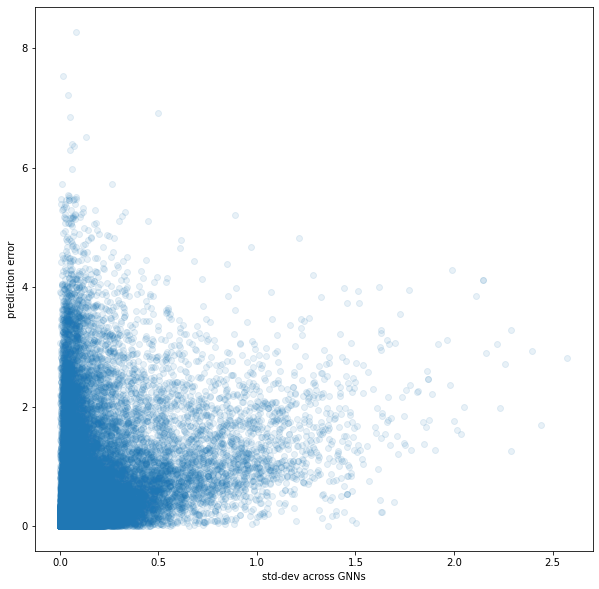

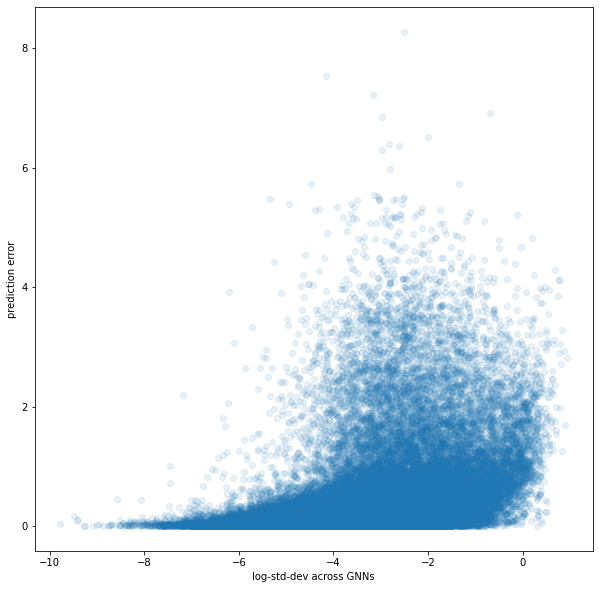

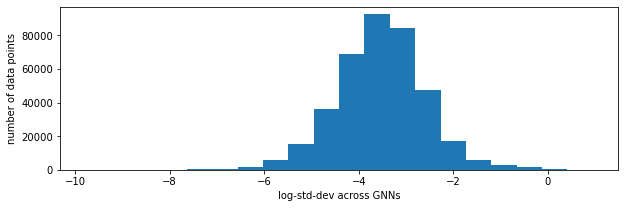

In [87]:
pairs = (ginDF["gin-pred"], ginBNNDF["gin-pred"], ginDiffPoolDF["gin-diffpool-pred"])

std = np.std(list(zip(*pairs)), axis=1)
mean_pred = np.mean(list(zip(*pairs)), axis=1)
error = abs(y_true - mean_pred)
plt.figure(figsize=(10, 10))
plt.scatter(std, error, alpha=0.1)
plt.xlabel("std-dev across GNNs")
plt.ylabel("prediction error")
plt.show()
plt.figure(figsize=(10, 10))
plt.scatter(np.log(std), error, alpha=0.1)
plt.xlabel("log-std-dev across GNNs")
plt.ylabel("prediction error")
plt.show()

plt.figure(figsize=(10, 3))
plt.hist(np.log(std), bins=20)
plt.xlabel("log-std-dev across GNNs")
plt.ylabel("number of data points")
plt.show()

# seems like the higher the uncertainty, the higher the error

In [77]:
np.corrcoef(std, error)

array([[1.        , 0.42639377],
       [0.42639377, 1.        ]])

0.0 351449 0.10233624477533061
0.1 20570 0.3218846812383067
0.2 3745 0.6438838470602863
0.3 1572 0.8193365843165619
0.4 918 0.9195681704220429
0.5 601 1.0770223710977298
0.6 412 1.1422255113479773
0.7 343 1.153852495438156
0.8 258 1.27871718224937
0.9 228 1.3435022813534876
1.0 170 1.344213121778825
1.1 120 1.4483467393451268
1.2 80 1.7274599497516951
1.3 63 1.5221668828732124
1.4 58 1.5823619153307773
1.5 17 1.8647715437646009
1.6 23 1.9134403277134548
1.7 12 2.1618491278754344
1.8 10 2.0815605243047077
1.9 5 2.8167723655700683
2.0 4 1.7257911761601767
2.1 4 3.7479136188824973
2.2 5 2.456666898727417
2.3 1 2.9397741953531904
2.4 1 1.6865571339925127
2.5 1 2.8214722474416094


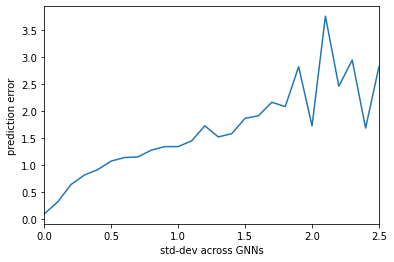

In [85]:
stdDF = pd.DataFrame(zip(y_true, std, mean_pred, error), columns=["y_true", "std", "mean_pred", "error"])
stdDF["std_cluster"] = stdDF["std"].apply(lambda x: int(x*10)/10)
# stdDF["std_cluster"] = stdDF["std"].apply(lambda x: int(np.log(x)))

errorPerStd = []
for std_cluster, rowDF in stdDF.groupby("std_cluster"):
    evaluator = PCQM4MEvaluator()
    input_dict = {"y_true": torch.tensor(rowDF["y_true"].values), "y_pred": torch.tensor(rowDF["mean_pred"].values)}
    mae = evaluator.eval(input_dict)["mae"]
    print(std_cluster, rowDF.shape[0], mae)
    errorPerStd.append([std_cluster, mae])
    
errorPerStd = np.array(errorPerStd)

plt.plot(errorPerStd[:, 0], errorPerStd[:, 1])
plt.xlim(0, 2.5)
plt.xlabel("std-dev across GNNs")
plt.ylabel("prediction error")
plt.show()

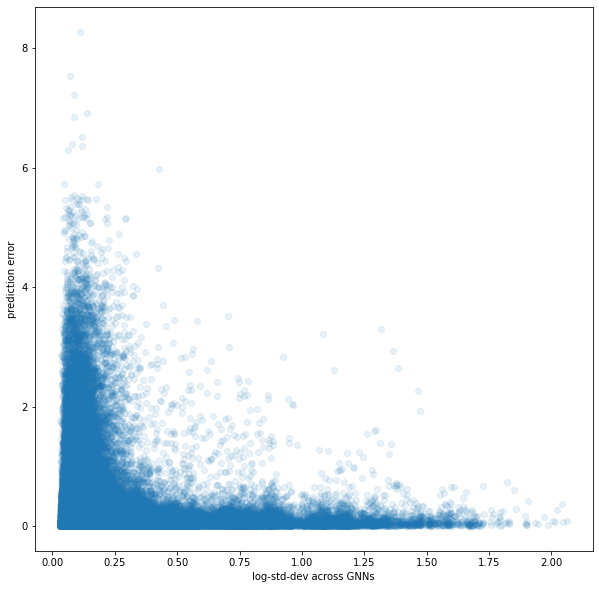

In [88]:
stdDF = stdDF.sort_values("std")

rollingAvg = stdDF["error"].rolling(100).mean()
plt.figure(figsize=(10, 10))
plt.scatter(rollingAvg, error, alpha=0.1)
plt.xlabel("log-std-dev across GNNs")
plt.ylabel("prediction error")
plt.show()

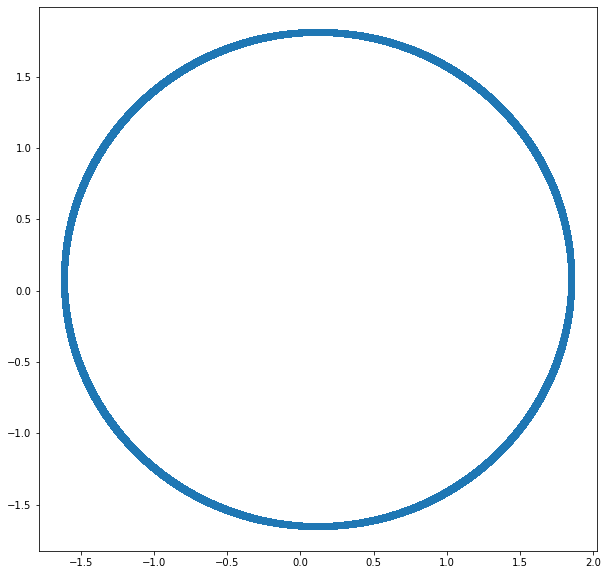

In [107]:
"""
pca to analyse difference
"""

import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = pd.DataFrame(zip(*pairs))
X = scaler.fit_transform(X.T).T

pca = PCA(n_components=2)
X_embed = pca.fit_transform(X)

plt.figure(figsize=(10, 10))
plt.scatter(X_embed[:, 0], X_embed[:, 1], alpha=0.3)
plt.show()